# Data Source
* [Food Production](https://www.fao.org/faostat/en/#data/QCL)

# Data Preparation

In [22]:
# Get all necessary packages
import pandas as pd
import os
import scipy.stats as stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

In [23]:
food_prod = pd.read_csv("data" + os.sep + "food production" + os.sep + "Production_Crops_Livestock_E_All_Data_NOFLAG.csv", sep=",", encoding="latin-1")
food_prod.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019,Y2020
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,ha,NaN,NaN,NaN,...,13469.0,13490.0,14114.0,13703.0,14676.0,19481.0,19793.0,20053.0,29203.0,22134.0
1,2,Afghanistan,221,"Almonds, with shell",5419,Yield,hg/ha,NaN,NaN,NaN,...,45000.0,45960.0,29910.0,19996.0,16521.0,16859.0,13788.0,17161.0,13083.0,17759.0
2,2,Afghanistan,221,"Almonds, with shell",5510,Production,tonnes,NaN,NaN,NaN,...,60611.0,62000.0,42215.0,27400.0,24246.0,32843.0,27291.0,34413.0,38205.0,39307.0
3,2,Afghanistan,711,"Anise, badian, fennel, coriander",5312,Area harvested,ha,NaN,NaN,NaN,...,19500.0,18500.0,18500.0,30000.0,25000.0,24500.0,26500.0,25333.0,25444.0,25759.0
4,2,Afghanistan,711,"Anise, badian, fennel, coriander",5419,Yield,hg/ha,NaN,NaN,NaN,...,6414.0,6757.0,6757.0,7167.0,7200.0,7075.0,7149.0,7142.0,7123.0,7138.0


In [24]:
# only use production amounts
food_prod = food_prod[food_prod["Element"] == "Production"]
food_prod.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019,Y2020
2,2,Afghanistan,221,"Almonds, with shell",5510,Production,tonnes,NaN,NaN,NaN,...,60611.0,62000.0,42215.0,27400.0,24246.0,32843.0,27291.0,34413.0,38205.0,39307.0
5,2,Afghanistan,711,"Anise, badian, fennel, coriander",5510,Production,tonnes,NaN,NaN,NaN,...,12508.0,12500.0,12500.0,21500.0,18000.0,17333.0,18944.0,18093.0,18123.0,18387.0
8,2,Afghanistan,515,Apples,5510,Production,tonnes,15100.0,15100.0,15100.0,...,62041.0,70000.0,78597.0,89403.0,89733.0,140903.0,170443.0,217192.0,250324.0,270857.0
11,2,Afghanistan,526,Apricots,5510,Production,tonnes,32000.0,32000.0,32000.0,...,67995.0,83500.0,90000.0,90000.0,87686.0,17894.0,131816.0,109086.0,129363.0,131788.0
15,2,Afghanistan,44,Barley,5510,Production,tonnes,378000.0,378000.0,378000.0,...,305900.0,504000.0,514000.0,521000.0,403000.0,301856.0,94995.0,56781.0,123576.0,127757.0


In [25]:
# only use the production data iself without the meta data
food_prod = food_prod.iloc[:,7:]
food_prod.head()

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019,Y2020
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,60611.0,62000.0,42215.0,27400.0,24246.0,32843.0,27291.0,34413.0,38205.0,39307.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12508.0,12500.0,12500.0,21500.0,18000.0,17333.0,18944.0,18093.0,18123.0,18387.0
8,15100.0,15100.0,15100.0,18400.0,20400.0,22800.0,27600.0,27900.0,28200.0,27300.0,...,62041.0,70000.0,78597.0,89403.0,89733.0,140903.0,170443.0,217192.0,250324.0,270857.0
11,32000.0,32000.0,32000.0,39200.0,43400.0,48400.0,58700.0,59400.0,60000.0,58100.0,...,67995.0,83500.0,90000.0,90000.0,87686.0,17894.0,131816.0,109086.0,129363.0,131788.0
15,378000.0,378000.0,378000.0,380000.0,380000.0,375000.0,357000.0,361000.0,365000.0,370000.0,...,305900.0,504000.0,514000.0,521000.0,403000.0,301856.0,94995.0,56781.0,123576.0,127757.0


In [26]:
# Calculate total sums for the years
food_prod = food_prod.sum(axis=0)
food_prod = pd.DataFrame(pd.Series(food_prod))
food_prod.columns = ["Production"]
food_prod.tail()

,Production
Y2016,1.090368e+11
Y2017,1.120533e+11
Y2018,1.130403e+11
Y2019,1.146314e+11
Y2020,1.103574e+11


Text(0.5, 0, 'Year')

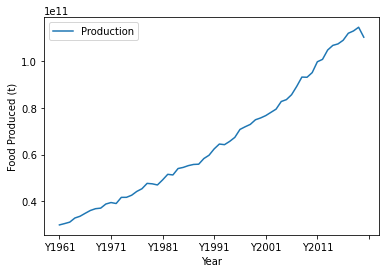

In [27]:
# Plot it
ax= food_prod.plot()
ax.set_ylabel("Food Produced (t)")
ax.set_xlabel("Year")
# Is the drop in 2020 real?

# Calculate the food shocks

In [28]:
# Calculate the percentage change in food production each year
food_prod["prc_change"] = food_prod["Production"].pct_change()*100
food_prod.head()

,Production,prc_change
Y1961,2.978441e+10,NaN
Y1962,3.035268e+10,1.907962
Y1963,3.097957e+10,2.065330
Y1964,3.275143e+10,5.719473
Y1965,3.350449e+10,2.299293


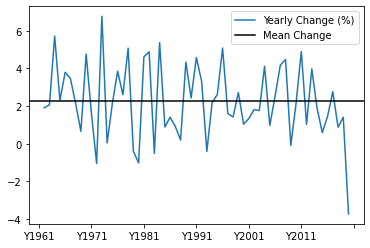

In [29]:
# Plot the percentage food production changes
ax = food_prod["prc_change"].plot(label="Yearly Change (%)")
ax.axhline(food_prod["prc_change"].mean(), label="Mean Change",color="black")
ax.legend()

In [30]:
# Calculate diff to mean change
food_prod["Difference"] = food_prod["prc_change"] - food_prod["prc_change"].mean()

Text(0, 0.5, 'Difference in global production to mean')

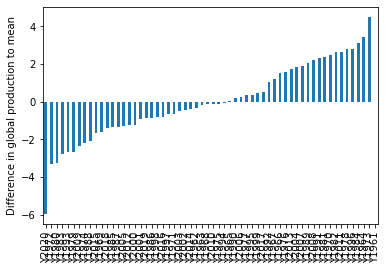

In [31]:
# plot the sorted difference
ax = food_prod["Difference"].sort_values().plot(kind="bar")
ax.set_ylabel("Difference in global production to mean")

# Cumulative distribution fitting with power law

In [32]:
# Set all values above 0 to 0, as we are only interested in the shocks
food_prod["Difference"] = food_prod["Difference"].where(food_prod["Difference"]<0, other=0)

In [33]:
# set all negative values to absolute values to make the fitting more straightforward
food_prod["Difference"] = abs(food_prod["Difference"])

In [34]:
# Sort for further calculations with cumsum
food_prod=food_prod.sort_values("Difference",ascending=False)

In [35]:
# calculate the time fraction
years = food_prod.shape[0]
food_prod["time"] = 1/years
food_prod["time"] = np.cumsum(food_prod["time"])
food_prod.head()

,Production,prc_change,Difference,time
Y2020,1.103574e+11,-3.728487,5.992450,0.016667
Y1972,3.896966e+10,-1.053685,3.317647,0.033333
Y1980,4.693613e+10,-1.022995,3.286958,0.050000
Y1983,5.123558e+10,-0.514436,2.778399,0.066667
Y1993,6.423281e+10,-0.408120,2.672082,0.083333


Text(0.5, 1.0, 'Probability of food shock')

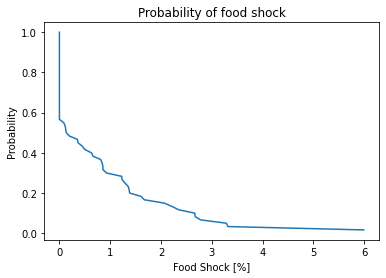

In [36]:
# Plot
fig = plt.Figure()
plt.plot(food_prod["Difference"], food_prod["time"])
ax = plt.gca()
ax.set_xlabel("Food Shock [%]")
ax.set_ylabel("Probability")
ax.set_title("Probability of food shock")

In [43]:
# Fit data to power law
def func_powerlaw(x, m, c, c0):
    return c0 + x**m * c
# Provide values for the parameters to avoid them becoming to negative?
params, covar = curve_fit(func_powerlaw, food_prod["Difference"], food_prod["time"], maxfev=100000)
params

array([ 0.32192673, -0.49009578,  0.78361965])

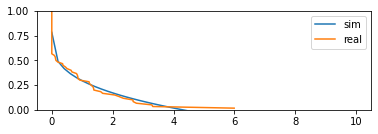

In [44]:
# Plot the power law
x_sim = np.linspace(0,10)
y_sim = func_powerlaw(x_sim, params[0], params[1], params[2])
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(x_sim, y_sim, label="sim")
ax.plot(food_prod["Difference"], food_prod["time"], label="real")
ax.set_ylim([0,1])
ax.legend()
#ax.set_xscale("log")

Looks like a good fit. Only problem is the outlier of 2020. Was there really such a large shock?

In [39]:
# Probability of food shock
food_shocks = np.array([1,2,3,4,5,6,7,8,9,10])
probs = func_powerlaw(food_shocks, params[0], params[1], params[2])
for i in range(len(food_shocks)):
    print("Food Shock [%]: " + (str(food_shocks[i])))
    print("Probability of food shock this size any given year: " + str(probs[i]))

Food Shock [%]: 1
Probability of food shock this size any given year: 0.27489582964847725
Food Shock [%]: 2
Probability of food shock this size any given year: 0.27489586644640723
Food Shock [%]: 3
Probability of food shock this size any given year: 0.27489588797181863
Food Shock [%]: 4
Probability of food shock this size any given year: 0.2748959032443421
Food Shock [%]: 5
Probability of food shock this size any given year: 0.2748959150906322
Food Shock [%]: 6
Probability of food shock this size any given year: 0.2748959247697564
Food Shock [%]: 7
Probability of food shock this size any given year: 0.27489593295333953
Food Shock [%]: 8
Probability of food shock this size any given year: 0.2748959400422819
Food Shock [%]: 9
Probability of food shock this size any given year: 0.2748959462951724
Food Shock [%]: 10
Probability of food shock this size any given year: 0.27489595188857363


# Fitting cumulative distribution in loglog space

In [40]:
# Transform data to loglog space
log_food_shock = np.log(food_prod["Difference"])
log_time = np.log(food_prod["time"])

/home/florian/local/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [41]:
# Fit data to power law
def func_powerlaw(x, m, c, c0):
    return c0 + x**m * c
# Provide values for the parameters to avoid them becoming to negative?
params, covar = curve_fit(func_powerlaw, log_food_shock, log_time, maxfev=100000000)
params

/home/florian/local/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


array([1., 1., 1.])

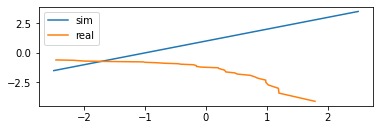

In [42]:
# Plot the power law
x_sim = np.linspace(-2.5,2.5)
y_sim = func_powerlaw(x_sim, params[0], params[1], params[2])
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(x_sim, y_sim, label="sim")
ax.plot(log_food_shock, log_time, label="real")
ax.legend()
#ax.set_ylim([0,1])
#ax.set_xscale("log")